# Project Time Series


In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Set figure size to(14,6)
plt.rcParams['figure.figsize'] = (14,6)

## 1) Define the Business Goal

Build a model that can predict tomorrows temperature as precisely as possible.


In [2]:
weather = pd.read_csv('/mnt/c/Users/noram/Documents/Coding/SpicedAcademy/Week05/ECA_blended_custom/wetter.csv', sep=",", index_col=1, parse_dates=True)
weather 
        

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2020-10-27,111448,100,0
2020-10-28,111448,105,0
2020-10-29,111448,104,0


In [3]:
weather.head

<bound method NDFrame.head of              SOUID     TG   Q_TG
    DATE                        
1876-01-01  127488     22      0
1876-01-02  127488     25      0
1876-01-03  127488      3      0
1876-01-04  127488    -58      0
1876-01-05  127488    -98      0
...            ...    ...    ...
2020-10-27  111448    100      0
2020-10-28  111448    105      0
2020-10-29  111448    104      0
2020-10-30  111448    114      0
2020-10-31  111448    139      0

[52900 rows x 3 columns]>

In [4]:
weather.shape

(52900, 3)

In [5]:
weather.isna().any()

 SOUID    False
   TG     False
 Q_TG     False
dtype: bool

In [6]:
plt.figure(figsize=(20,10))
#sns.pairplot(data=weather, y_vars=weather['Temp'], x_vars=weather.columns)

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## Cleaning data

In [7]:
weather['year'] = weather.index.year
weather.head()

,SOUID,TG,Q_TG,year
DATE,,,,
1876-01-01,127488,22,0,1876
1876-01-02,127488,25,0,1876
1876-01-03,127488,3,0,1876
1876-01-04,127488,-58,0,1876
1876-01-05,127488,-98,0,1876


In [8]:
weather['day'] = weather.index.day
weather.head()

,SOUID,TG,Q_TG,year,day
DATE,,,,,
1876-01-01,127488,22,0,1876,1
1876-01-02,127488,25,0,1876,2
1876-01-03,127488,3,0,1876,3
1876-01-04,127488,-58,0,1876,4
1876-01-05,127488,-98,0,1876,5


In [9]:
weather['month'] = weather.index.month
weather.head()

,SOUID,TG,Q_TG,year,day,month
DATE,,,,,,
1876-01-01,127488,22,0,1876,1,1
1876-01-02,127488,25,0,1876,2,1
1876-01-03,127488,3,0,1876,3,1
1876-01-04,127488,-58,0,1876,4,1
1876-01-05,127488,-98,0,1876,5,1


In [10]:
weather['timestep'] = list(range(len(weather)))
weather.head()

,SOUID,TG,Q_TG,year,day,month,timestep
DATE,,,,,,,
1876-01-01,127488,22,0,1876,1,1,0
1876-01-02,127488,25,0,1876,2,1,1
1876-01-03,127488,3,0,1876,3,1,2
1876-01-04,127488,-58,0,1876,4,1,3
1876-01-05,127488,-98,0,1876,5,1,4


In [11]:
weather.columns

Index([' SOUID', '   TG', ' Q_TG', 'year', 'day', 'month', 'timestep'], dtype='object')

In [12]:
weather[weather['year']!=1945]

,SOUID,TG,Q_TG,year,day,month,timestep
DATE,,,,,,,
1876-01-01,127488,22,0,1876,1,1,0
1876-01-02,127488,25,0,1876,2,1,1
1876-01-03,127488,3,0,1876,3,1,2
1876-01-04,127488,-58,0,1876,4,1,3
1876-01-05,127488,-98,0,1876,5,1,4
...,...,...,...,...,...,...,...
2020-10-27,111448,100,0,2020,27,10,52895
2020-10-28,111448,105,0,2020,28,10,52896
2020-10-29,111448,104,0,2020,29,10,52897


In [13]:
def clean_weather(df):
    '''This function cleans the DF, 
    1.first it calculates the mean temperature 
    2. drops the missing data 
    
    Returns
    ------
    Clean the Dataset
    '''
    
    df['Temp'] = df['   TG']/10
    df = df[df['year']!=1945]
    return df

In [14]:
clean_weather(weather)

,SOUID,TG,Q_TG,year,day,month,timestep,Temp
DATE,,,,,,,,
1876-01-01,127488,22,0,1876,1,1,0,2.2
1876-01-02,127488,25,0,1876,2,1,1,2.5
1876-01-03,127488,3,0,1876,3,1,2,0.3
1876-01-04,127488,-58,0,1876,4,1,3,-5.8
1876-01-05,127488,-98,0,1876,5,1,4,-9.8
...,...,...,...,...,...,...,...,...
2020-10-27,111448,100,0,2020,27,10,52895,10.0
2020-10-28,111448,105,0,2020,28,10,52896,10.5
2020-10-29,111448,104,0,2020,29,10,52897,10.4


### Visualize your Data

In [15]:
def plot_weather(df, title='Yearly weather changes', ylim=True):
    '''
    Custom plotting function for plotting the weather dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title('weather mean temperature Celcius ')
    plt.ylabel('weather mean temperature Celcius ')
    if ylim:
        plt.ylim(ymin=-30)
    plt.show()

## Train test split data


In [17]:

df_train = weather[:-365]
df_test = weather[-365:]

In [34]:
custom_year = df_train.iloc[:365]

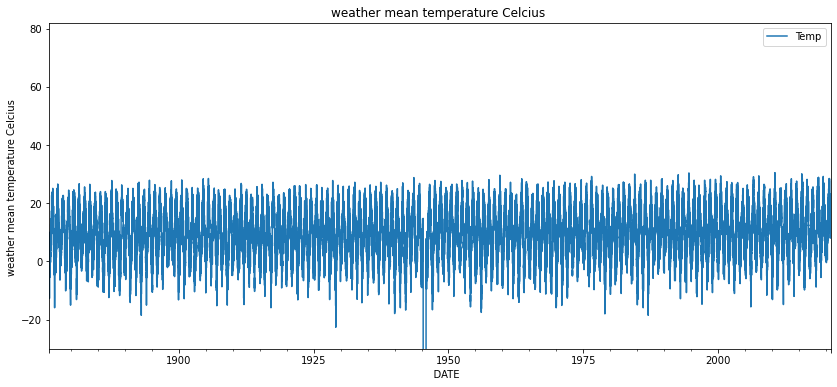

In [35]:
plot_weather(weather[['Temp']])


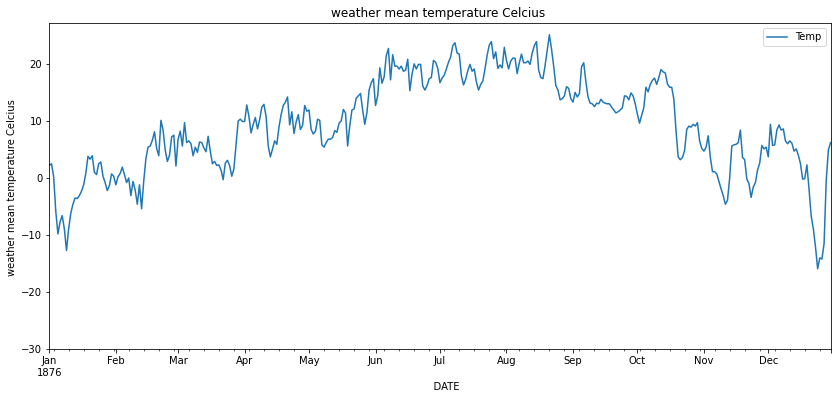

In [36]:
plot_weather(custom_year[['Temp']])

## Feature Engineer Data

Play around with a polynomial trend; it could fit your data better [m.score()]/you could look at the coefficients and determine whether they are significant

In [37]:
df_train['poly'] = df_train['Temp']**2
df_train

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,poly,trend,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,trend_season
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,22,0,1876,1,1,0,2.2,4.84,4.415833,...,0,0,0,0,0,0,0,0,0,4.096077
1876-01-02,127488,25,0,1876,2,1,1,2.5,6.25,4.415833,...,0,0,0,0,0,0,0,0,0,4.127626
1876-01-03,127488,3,0,1876,3,1,2,0.3,0.09,4.415833,...,0,0,0,0,0,0,0,0,0,4.153176
1876-01-04,127488,-58,0,1876,4,1,3,-5.8,33.64,4.415833,...,0,0,0,0,0,0,0,0,0,4.212736
1876-01-05,127488,-98,0,1876,5,1,4,-9.8,96.04,4.415833,...,0,0,0,0,0,0,0,0,0,4.197788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-28,111448,84,0,2019,28,10,52530,8.4,70.56,6.848970,...,0,0,0,0,0,1,0,0,0,6.614524
2019-10-29,111448,53,0,2019,29,10,52531,5.3,28.09,6.848970,...,0,0,0,0,0,0,1,0,0,6.829658
2019-10-30,111448,31,0,2019,30,10,52532,3.1,9.61,6.848970,...,0,0,0,0,0,0,0,1,0,6.917435


In [38]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(df_train)

array([[1.0000000e+00, 1.2748800e+05, 2.2000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.2748800e+05, 2.5000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.2748800e+05, 3.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 1.1144800e+05, 3.1000000e+01, ..., 0.0000000e+00,
        6.9174347e+00, 0.0000000e+00],
       [1.0000000e+00, 1.1144800e+05, 2.1000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 6.7138187e+00],
       [1.0000000e+00, 1.1144800e+05, 3.0000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [39]:
# Now assign X and y
#y_train = df_train_fe.copy().iloc[:,0]
#X_train = df_train_fe.copy().iloc[:,1:]

In [40]:
m = LinearRegression()
X_train = df_train[['year']]
y_train = df_train['Temp']
m.fit(X_train, y_train)
m.score(X_train, y_train)

0.0001303557413279144

In [41]:
df_train['trend'] = m.predict(X_train)
df_train.head()

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,poly,trend,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,trend_season
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,22,0,1876,1,1,0,2.2,4.84,4.415833,...,0,0,0,0,0,0,0,0,0,4.096077
1876-01-02,127488,25,0,1876,2,1,1,2.5,6.25,4.415833,...,0,0,0,0,0,0,0,0,0,4.127626
1876-01-03,127488,3,0,1876,3,1,2,0.3,0.09,4.415833,...,0,0,0,0,0,0,0,0,0,4.153176
1876-01-04,127488,-58,0,1876,4,1,3,-5.8,33.64,4.415833,...,0,0,0,0,0,0,0,0,0,4.212736
1876-01-05,127488,-98,0,1876,5,1,4,-9.8,96.04,4.415833,...,0,0,0,0,0,0,0,0,0,4.197788


In [42]:
day_dummies = pd.get_dummies(df_train.index.day,
                                  prefix='day',
                                  drop_first=True).set_index(df_train.index)

df_train = df_train.join(day_dummies,  lsuffix='index')

In [43]:
X_train1 = df_train[['timestep']].join(day_dummies)
y_train = df_train['Temp']
m.fit(X_train1,y_train)

LinearRegression()

In [44]:
df_train['trend_season'] = m.predict(X_train1)
df_train.head()

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,poly,trend,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,22,0,1876,1,1,0,2.2,4.84,4.415833,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,127488,25,0,1876,2,1,1,2.5,6.25,4.415833,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,127488,3,0,1876,3,1,2,0.3,0.09,4.415833,...,0,0,0,0,0,0,0,0,0,0
1876-01-04,127488,-58,0,1876,4,1,3,-5.8,33.64,4.415833,...,0,0,0,0,0,0,0,0,0,0
1876-01-05,127488,-98,0,1876,5,1,4,-9.8,96.04,4.415833,...,0,0,0,0,0,0,0,0,0,0


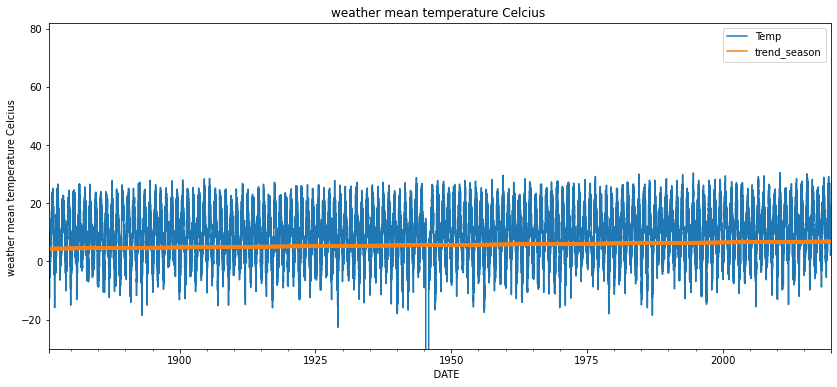

In [45]:
plot_weather(df_train[['Temp','trend_season']])

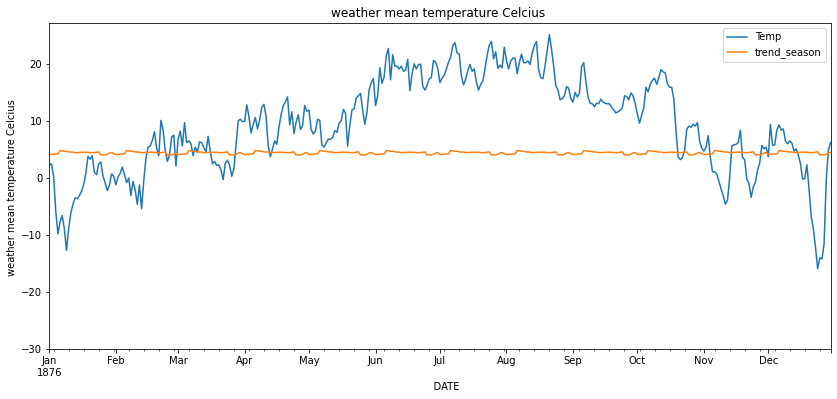

In [46]:
plot_weather(custom_year[['Temp', 'trend_season']])

In [47]:
df_train['remainder'] = (df_train['Temp']- df_train['trend_season'])
df_train['remainder']

    DATE
1876-01-01    -1.896077
1876-01-02    -1.627626
1876-01-03    -3.853176
1876-01-04   -10.012736
1876-01-05   -13.997788
                ...    
2019-10-28     1.785476
2019-10-29    -1.529658
2019-10-30    -3.817435
2019-10-31    -4.613819
2019-11-01    -3.554124
Name: remainder, Length: 52535, dtype: float64

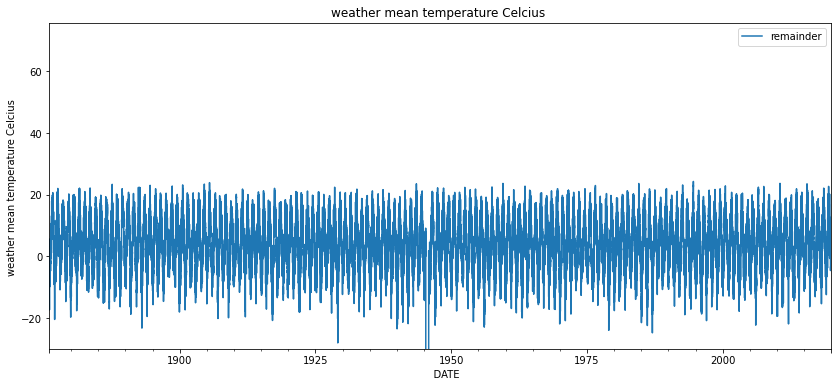

In [48]:
plot_weather(df_train[['remainder']])

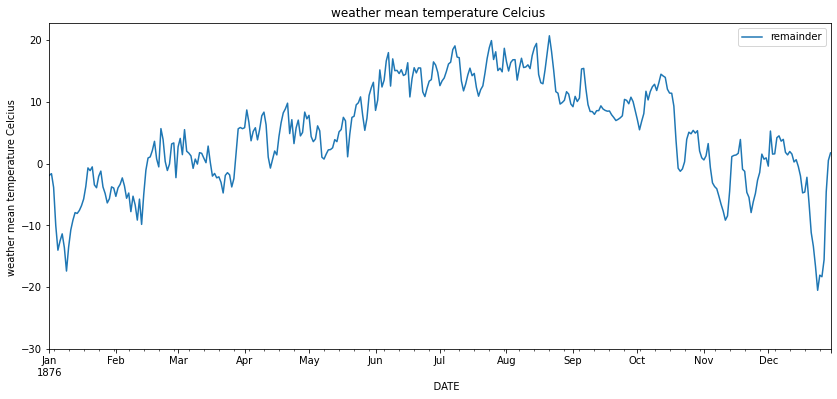

In [51]:
custom_year = df_train.iloc[:365]
plot_weather(custom_year[['remainder']])

In [50]:
m.score(X_train1, y_train)

0.00014325664867076426

In [52]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)

In [53]:
df_train.dropna(inplace=True)


In [54]:
round(df_train[['remainder', 'lag1', 'lag2', 'lag3']].corr(),2)


,remainder,lag1,lag2,lag3
remainder,1.00,0.99,0.99,0.98
lag1,0.99,1.00,0.99,0.99
lag2,0.99,0.99,1.00,0.99
lag3,0.98,0.99,0.99,1.00


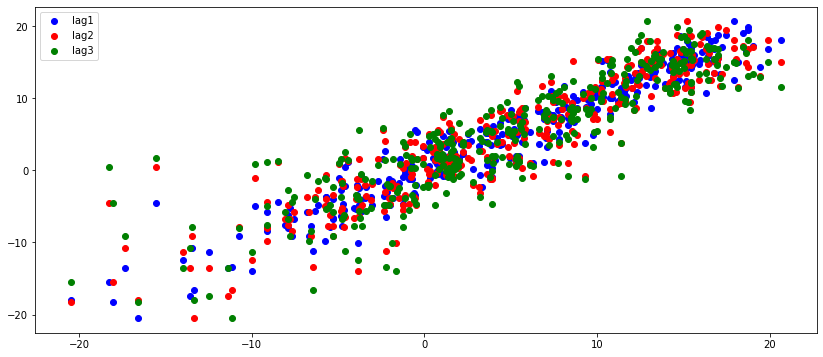

In [58]:
custom_year = df_train.iloc[:365]
plt.scatter(x = custom_year['lag1'], y= custom_year['remainder'], c ='blue')
plt.scatter(x = custom_year['lag2'], y= custom_year['remainder'], c ='red')
plt.scatter(x = custom_year['lag3'], y= custom_year['remainder'], c ='green')
plt.legend(['lag1','lag2','lag3'])

Next step: Add the lag of the remainder as a feature to your DataFrame and create a new model with the features timestep, seasonal_dummies, lag1 of the remainder

In [59]:
X_train2 = df_train[[ 'lag1']]
y_train = df_train['remainder']
m.fit(X_train2, y_train)
m.score(X_train2, y_train)

0.9884586097905718

In [60]:
df_train['predictions1'] = m.predict(X_train2)
df_train.head()

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,poly,trend,...,day_27,day_28,day_29,day_30,day_31,remainder,lag1,lag2,lag3,predictions1
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,127488,-58,0,1876,4,1,3,-5.8,33.64,4.415833,...,0,0,0,0,0,-10.012736,-3.853176,-1.627626,-1.896077,-3.830870
1876-01-05,127488,-98,0,1876,5,1,4,-9.8,96.04,4.415833,...,0,0,0,0,0,-13.997788,-10.012736,-3.853176,-1.627626,-9.954781
1876-01-06,127488,-77,0,1876,6,1,5,-7.7,59.29,4.415833,...,0,0,0,0,0,-12.501496,-13.997788,-10.012736,-3.853176,-13.916770
1876-01-07,127488,-66,0,1876,7,1,6,-6.6,43.56,4.415833,...,0,0,0,0,0,-11.357753,-12.501496,-13.997788,-10.012736,-12.429138
1876-01-08,127488,-89,0,1876,8,1,7,-8.9,79.21,4.415833,...,0,0,0,0,0,-13.566212,-11.357753,-12.501496,-13.997788,-11.292014


In [61]:
def plot_remainder(df, title='Remaining Temperature conditions'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    plt.show()

In [62]:
custom_year = df_train.iloc[:365]

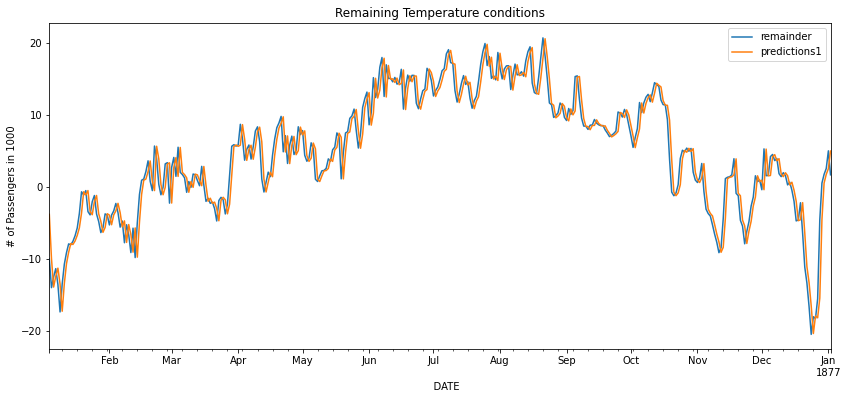

In [63]:
# Plot the original remainder and the prediction
plot_remainder(custom_year[['remainder', 'predictions1']])

In [64]:
df_train['residual'] = df_train['remainder'] - df_train['predictions1']
df_train.head()

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,poly,trend,...,day_28,day_29,day_30,day_31,remainder,lag1,lag2,lag3,predictions1,residual
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,127488,-58,0,1876,4,1,3,-5.8,33.64,4.415833,...,0,0,0,0,-10.012736,-3.853176,-1.627626,-1.896077,-3.830870,-6.181866
1876-01-05,127488,-98,0,1876,5,1,4,-9.8,96.04,4.415833,...,0,0,0,0,-13.997788,-10.012736,-3.853176,-1.627626,-9.954781,-4.043007
1876-01-06,127488,-77,0,1876,6,1,5,-7.7,59.29,4.415833,...,0,0,0,0,-12.501496,-13.997788,-10.012736,-3.853176,-13.916770,1.415274
1876-01-07,127488,-66,0,1876,7,1,6,-6.6,43.56,4.415833,...,0,0,0,0,-11.357753,-12.501496,-13.997788,-10.012736,-12.429138,1.071385
1876-01-08,127488,-89,0,1876,8,1,7,-8.9,79.21,4.415833,...,0,0,0,0,-13.566212,-11.357753,-12.501496,-13.997788,-11.292014,-2.274198


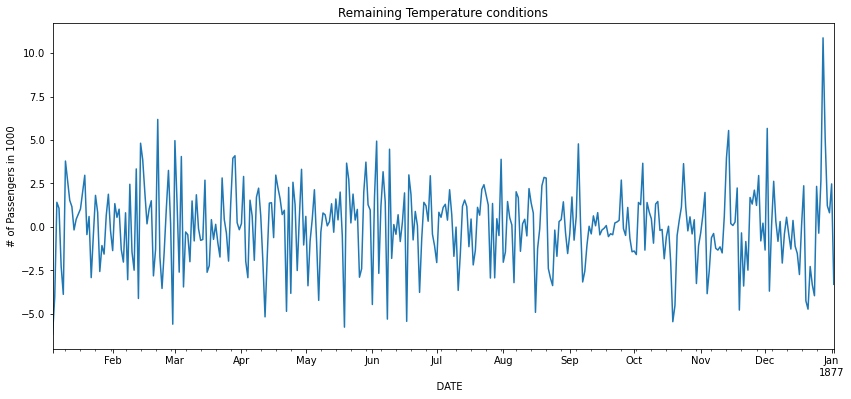

In [66]:
custom_year = df_train.iloc[:365]
plot_remainder(custom_year['residual'])

In [67]:
df_train.columns

Index([' SOUID', '   TG', ' Q_TG', 'year', 'day', 'month', 'timestep', 'Temp',
       'poly', 'trend', 'day_2index', 'day_3index', 'day_4index', 'day_5index',
       'day_6index', 'day_7index', 'day_8index', 'day_9index', 'day_10index',
       'day_11index', 'day_12index', 'day_13index', 'day_14index',
       'day_15index', 'day_16index', 'day_17index', 'day_18index',
       'day_19index', 'day_20index', 'day_21index', 'day_22index',
       'day_23index', 'day_24index', 'day_25index', 'day_26index',
       'day_27index', 'day_28index', 'day_29index', 'day_30index',
       'day_31index', 'trend_season', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12',
       'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19',
       'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26',
       'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'remainder', 'lag1',
       'lag2', 'lag3', 'predictions1', 'residual'

## Train Full model

In [68]:
X_full = df_train.drop(columns=['Temp','trend_season', 'remainder','trend','year','lag2','lag3','predictions1','residual','month','poly','   TG',' Q_TG'])
y_full = df_train['Temp']

In [69]:
X_full

,SOUID,day,timestep,day_2index,day_3index,day_4index,day_5index,day_6index,day_7index,day_8index,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,lag1
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,127488,4,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3.853176
1876-01-05,127488,5,4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-10.012736
1876-01-06,127488,6,5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-13.997788
1876-01-07,127488,7,6,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-12.501496
1876-01-08,127488,8,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-11.357753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-28,111448,28,52530,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.421397
2019-10-29,111448,29,52531,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.785476
2019-10-30,111448,30,52532,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,-1.529658


In [70]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [71]:
df_train['predictions_full_model'] = m_full.predict(X_full)
m_full.score(X_full, y_full)

0.9884614629657258

In [74]:
pd.DataFrame(m_full.coef_.reshape(1,64), columns=X_full.columns)

,SOUID,day,timestep,day_2index,day_3index,day_4index,day_5index,day_6index,day_7index,day_8index,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,lag1
0,-0.000011,0.005707,0.000042,-0.068358,-0.056711,-0.030466,-0.040815,0.258164,0.233418,0.184773,...,0.059585,0.088055,-0.189849,-0.164015,-0.191948,-0.126862,-0.124935,-0.014956,-0.004117,0.994133


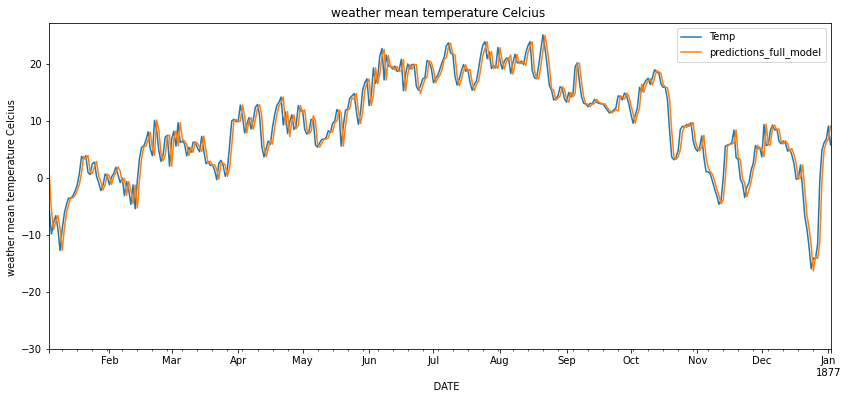

In [75]:
custom_year = df_train.iloc[:365]
plot_weather(custom_year[['Temp', 'predictions_full_model']])

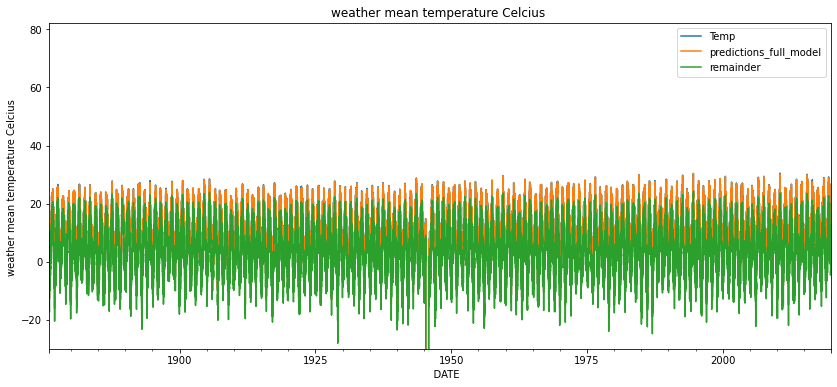

In [76]:
plot_weather(df_train[['Temp', 'predictions_full_model','remainder']])

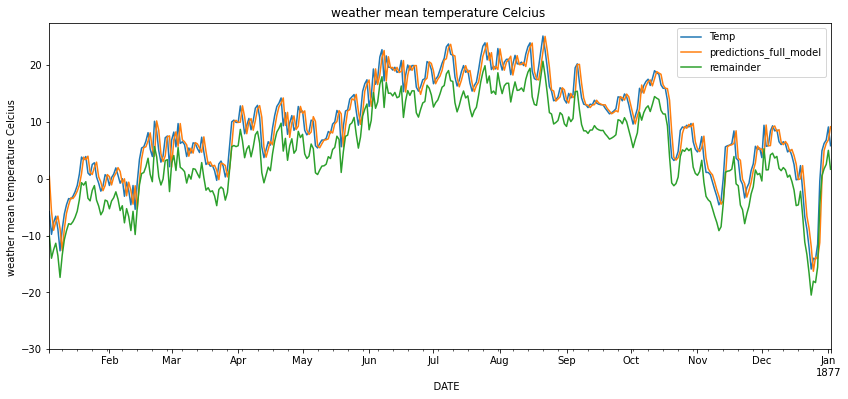

In [77]:
plot_weather(custom_year[['Temp', 'predictions_full_model','remainder']])

##  Cross-Validate and Optimize Hyperparameters

In [78]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=10)

In [79]:
#split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training dat for the {i}th iteration are the observations {train_index}')
    print(f'The validtion data for the{i+1}th iteration are the observations {validation_index}')

The training dat for the 0th iteration are the observations [   0    1    2 ... 4779 4780 4781]
The validtion data for the1th iteration are the observations [4782 4783 4784 ... 9554 9555 9556]
The training dat for the 1th iteration are the observations [   0    1    2 ... 9554 9555 9556]
The validtion data for the2th iteration are the observations [ 9557  9558  9559 ... 14329 14330 14331]
The training dat for the 2th iteration are the observations [    0     1     2 ... 14329 14330 14331]
The validtion data for the3th iteration are the observations [14332 14333 14334 ... 19104 19105 19106]
The training dat for the 3th iteration are the observations [    0     1     2 ... 19104 19105 19106]
The validtion data for the4th iteration are the observations [19107 19108 19109 ... 23879 23880 23881]
The training dat for the 4th iteration are the observations [    0     1     2 ... 23879 23880 23881]
The validtion data for the5th iteration are the observations [23882 23883 23884 ... 28654 28655 

In [80]:
time_series_split = ts_split.split(X_full, y_full)

In [81]:
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
result

array([ 9.20775074e-01,  9.03253477e-01,  8.91106629e-01,  9.07832740e-01,
       -1.69136261e+13,  9.04976391e-01,  9.07856130e-01,  9.00045490e-01,
        9.11760034e-01,  9.15074662e-01])

## Testing the Model

In [138]:
df_test = weather[-365:]
df_test

,SOUID,TG,Q_TG,year,day,month,timestep,Temp
DATE,,,,,,,,
2019-11-02,111448,113,0,2019,2,11,52535,11.3
2019-11-03,111448,109,0,2019,3,11,52536,10.9
2019-11-04,111448,104,0,2019,4,11,52537,10.4
2019-11-05,111448,95,0,2019,5,11,52538,9.5
2019-11-06,111448,82,0,2019,6,11,52539,8.2
...,...,...,...,...,...,...,...,...
2020-10-27,111448,100,0,2020,27,10,52895,10.0
2020-10-28,111448,105,0,2020,28,10,52896,10.5
2020-10-29,111448,104,0,2020,29,10,52897,10.4


In [139]:
df_test = df_test.copy()
day_dummies = pd.get_dummies(df_test.index.day,
                                  prefix='day',
                                  drop_first=True).set_index(df_test.index)
df_test = df_test.join(day_dummies) #lsuffix='index')
    

In [140]:
df_test.head()

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,day_2,day_3,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
DATE,,,,,,,,,,,,,,,,,,,,,
2019-11-02,111448,113,0,2019,2,11,52535,11.3,1,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-03,111448,109,0,2019,3,11,52536,10.9,0,1,...,0,0,0,0,0,0,0,0,0,0
2019-11-04,111448,104,0,2019,4,11,52537,10.4,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-05,111448,95,0,2019,5,11,52538,9.5,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-06,111448,82,0,2019,6,11,52539,8.2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
#def feature_engineer(df):
    '''
  #  This function feature engineers the data inorder to fit the model. It can be applied for the training and testing data
    '''
   # df['day'] = df.index.day
   # df = df.copy()
   # day_dummies = pd.get_dummies(df.index.day,
                                  #prefix='day',
                                 # drop_first=True).set_index(df.index)

   # df = df.join(day_dummies) #lsuffix='index')
   # return df

In [136]:
#df_test_fe = feature_engineer(df_test)

In [141]:
X_test = df_test_fe[['timestep']].join(day_dummies)
y_test = df_test_fe['Temp']
m.fit(X_test,y_test)

LinearRegression()

In [142]:
df_test['trend_season'] = m.predict(X_test)
df_test.head()

,SOUID,TG,Q_TG,year,day,month,timestep,Temp,day_2,day_3,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,trend_season
DATE,,,,,,,,,,,,,,,,,,,,,
2019-11-02,111448,113,0,2019,2,11,52535,11.3,1,0,...,0,0,0,0,0,0,0,0,0,3.809231
2019-11-03,111448,109,0,2019,3,11,52536,10.9,0,1,...,0,0,0,0,0,0,0,0,0,4.259231
2019-11-04,111448,104,0,2019,4,11,52537,10.4,0,0,...,0,0,0,0,0,0,0,0,0,3.925897
2019-11-05,111448,95,0,2019,5,11,52538,9.5,0,0,...,0,0,0,0,0,0,0,0,0,2.875897
2019-11-06,111448,82,0,2019,6,11,52539,8.2,0,0,...,0,0,0,0,0,0,0,0,0,3.717564


In [143]:
df_test['remainder_test'] = (df_test['Temp']- df_test['trend_season'])
df_test['remainder_test']

    DATE
2019-11-02    7.490769
2019-11-03    6.640769
2019-11-04    6.474103
2019-11-05    6.624103
2019-11-06    4.482436
                ...   
2020-10-27   -9.272375
2020-10-28   -9.355708
2020-10-29   -7.880708
2020-10-30   -6.834397
2020-10-31   -5.250297
Name: remainder_test, Length: 365, dtype: float64

In [144]:
df_test['lag1'] = df_test['remainder_test'].shift(1)
df_test['lag2'] = df_test['remainder_test'].shift(2)
df_test['lag3'] = df_test['remainder_test'].shift(3)

In [145]:
df_test.dropna(inplace=True)

In [146]:
X_full_test = df_test.drop(columns=['Temp', 'trend_season', 'remainder_test','lag2','lag3', '   TG', ' Q_TG','year',' SOUID','month'])
y_full_test = df_test['Temp']

In [147]:
X_full_test.columns

Index(['day', 'timestep', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'lag1'],
      dtype='object')

In [148]:
m_full = LinearRegression()
m_full.fit(X_full_test, y_full_test)

LinearRegression()

In [153]:
df_test['predictions_full_model_test'] = m_full.predict(X_full_test)
m_full.score(X_full_test, y_full_test)

0.9033547280223619

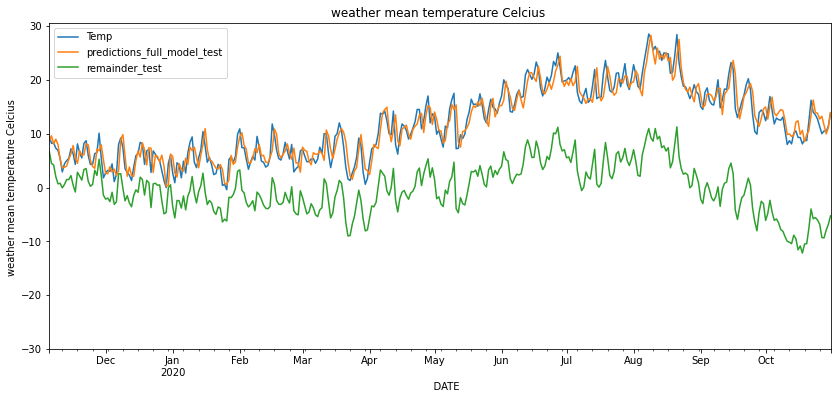

In [156]:
plot_weather(df_test[['Temp', 'predictions_full_model_test','remainder_test']])

In [155]:
custom_day = df_test.iloc[:55]

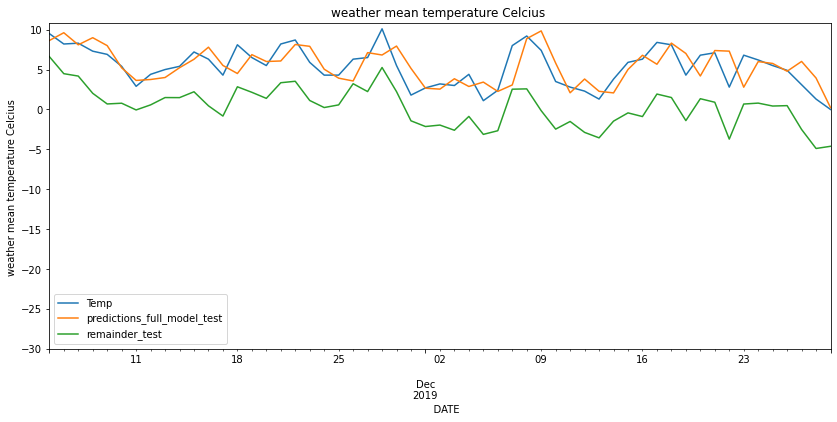

In [157]:
plot_weather(custom_day[['Temp', 'predictions_full_model_test','remainder_test']])

## Statsmodel AutoReg

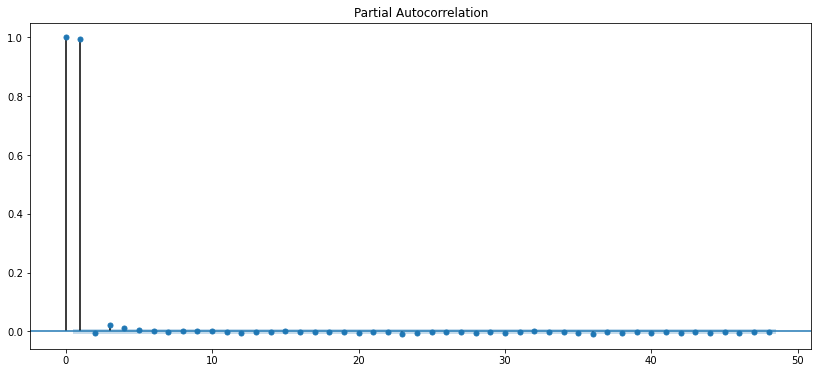

In [89]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train['remainder']);

In [90]:
selected_order = ar_select_order(df_train['remainder'], maxlag=10)

/home/nora/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nora/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [91]:
selected_order.ar_lags

array([1, 2, 3])

In [92]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=df_train['remainder'], lags=1).fit()
ar_model = AutoReg(endog=df_train['remainder'], lags=2).fit()
ar_model = AutoReg(endog=df_train['remainder'], lags=3).fit()           

/home/nora/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nora/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nora/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [93]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52532
Model:                     AutoReg(3)   Log Likelihood             -174025.887
Method:               Conditional MLE   S.D. of innovations              6.646
Date:                Thu, 17 Dec 2020   AIC                              3.788
Time:                        15:26:29   BIC                              3.789
Sample:                    01-07-1876   HQIC                             3.788
                         - 11-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.029      0.006      0.995      -0.057       0.057
remainder.L1     0.9994      0.004    229.104      0.000       0.991       1.008
remainder.L2    -0.0257      0.006     -4.164      0.000      -0.038      -0.014
remainder.L3     0.0206      0.004      4.718      0.000       0.012       0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0056           -0.0000j            1.0056           -0.0000
AR.2            0.1211           -6.9498j            6.9509           -0.2472
AR.3            0.1211           +6.9498j            6.9509            0.2472
-----------------------------------------------------------------------------
"""